In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import subprocess
import os
import os.path
import time
import tempfile
import shutil
import logging
import urllib

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
logging.getLogger("").setLevel(logging.DEBUG)

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
logging.getLogger("").addHandler(ch)

logger = logging.getLogger("main")
logger.debug("Test")

Test


In [3]:
#git_url = "git@github.com:babrodtk/gpu-ocean.git"
git_url = None
try:
    git_url = subprocess.check_output(["git", "rev-parse", "--show-toplevel"], stderr=subprocess.STDOUT, shell=True)
    git_url = os.path.abspath(os.path.join(git_url.decode("utf-8").rstrip(), ".git"))
except subprocess.CalledProcessError as e:
    logger.error("Failed, return code " + str(e.returncode) + "\n" + str(e.output))
logger.info(git_url)
    
    
benchmark_script_relpath = "gpu_ocean/demos/testCasesDemos/run_benchmark.py"
benchmark_script_version = "5c2214573269367fbdb6d67ace07f2ffa57d37ba"
benchmark_script_options = ["--simulator", "CDKLM", '--steps_per_download', '10', '--iterations', '3']
outfile = os.path.join(os.getcwd(), "output.npz")


git_versions = [
    ("a126bab97e690b7c642814e3c8b96f9879adf487", "original (per arch optimized block size)"), #Change blocksize here!
    ("5d817bb7cd2b369039117d19aae7d669a9a2e53a", "Optimized shared memory use Hm"),
    ("2e5da01457874ad5087398da77b9102ee991fb94", "Optimized shared memory use RHx/RHy"),
    ("fcd145c8c29f3d38a024685fdd0fc3cf9580366c", "Optimized shared memory use Q"),
    ("74e957bb41e391a5c5fbb19c3cac393079272dd3", "Optimized shared memory use F"),
    ("5aba525d1d64937c03e8d2b33bb7f6d80b97a81a", "Optimized shared memory use G"),
    ("addb061fe1cfccebb6fab70f9826be3752162b0b", "Optimized shared memory use Qy"),
    ("aab115045fd6d313940fa37be3149155ba4ead70", "Made variables const"),
    ("f6a911368b429df608eb5e1218c28bc14d6ffbe2", "Updated blocksize experiment code"),
    ("339eb0c9a3bf04875507fab24d8924e24718a2eb", "Changed default block size"), #Change blocksize here!
    ("1319edf92c20b8d5fd9fc8c0e0ed58176f9cc2ba", "Tried to reduce register use"),
    ("6de871265b820aecc63d68a2e1f858605eb367c7", "Refactored to optimize register use"),
    ("f6d1727d747b486203df91079b83a9e717668852", "Added logger to CDKLM"),
    ("40f9d4817fa084de7cebfd3cf6d20254b93e7393", "Added fast math compilation flag"),
    #("e2af2159becbd3c8769903eb4bea602a96d6c3a1", "Compilation flags experimentation"),
    ("12536844bdc4459dcf4cc92776faea3a81d0a32c", "New optimal block size") #Change blocksize here!
]

for version, log in git_versions:
    logger.info(version + " - " + log)

c:\Users\anbro\Documents\projects\ocean_drift\gpu-ocean\.git
a126bab97e690b7c642814e3c8b96f9879adf487 - original (per arch optimized block size)
5d817bb7cd2b369039117d19aae7d669a9a2e53a - Optimized shared memory use Hm
2e5da01457874ad5087398da77b9102ee991fb94 - Optimized shared memory use RHx/RHy
fcd145c8c29f3d38a024685fdd0fc3cf9580366c - Optimized shared memory use Q
74e957bb41e391a5c5fbb19c3cac393079272dd3 - Optimized shared memory use F
5aba525d1d64937c03e8d2b33bb7f6d80b97a81a - Optimized shared memory use G
addb061fe1cfccebb6fab70f9826be3752162b0b - Optimized shared memory use Qy
aab115045fd6d313940fa37be3149155ba4ead70 - Made variables const
f6a911368b429df608eb5e1218c28bc14d6ffbe2 - Updated blocksize experiment code
339eb0c9a3bf04875507fab24d8924e24718a2eb - Changed default block size
1319edf92c20b8d5fd9fc8c0e0ed58176f9cc2ba - Tried to reduce register use
6de871265b820aecc63d68a2e1f858605eb367c7 - Refactored to optimize register use
f6d1727d747b486203df91079b83a9e717668852 - Adde

In [4]:
#Create temporary directory
tmpdir = tempfile.mkdtemp(prefix='git_tmp')
logger.debug("Writing to " + tmpdir)

Writing to C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg


In [5]:
def git(cwd, options):
    a = None
    try:
        cmd = ["git"] + options
        logger.debug("Git cloning: " + cwd + " -- " + str(cmd))
        a = subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=True, cwd=cwd)
    except subprocess.CalledProcessError as e:
        logger.error("Failed, return code " + str(e.returncode) + "\n" + str(e.output))
    return a.decode("utf-8") 

    
git_clone = os.path.join(tmpdir, "git_clone")
stdout = git(tmpdir, ["clone", git_url, git_clone])
logger.debug(stdout)

Git cloning: C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg -- ['git', 'clone', 'c:\\Users\\anbro\\Documents\\projects\\ocean_drift\\gpu-ocean\\.git', 'C:\\Users\\anbro\\AppData\\Local\\Temp\\git_tmpxveo_1rg\\git_clone']
Cloning into 'C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone'...
done.



In [6]:
for version, log in git_versions:
    logger.debug("checkout " + version)
    stdout = git(git_clone, ["checkout", "--force", '-q', version])
    logger.debug("stdout: " + str(stdout))
    
    logger.debug("Checkout " + benchmark_script_relpath)
    stdout = git(git_clone, ["checkout", "--force", '-q', benchmark_script_version, "--", benchmark_script_relpath])
    logger.debug("stdout: " + str(stdout))
    
    
    a = None
    try:
        cmd = ["python", os.path.join(git_clone, benchmark_script_relpath)] + benchmark_script_options + ["--output", "benchmark_" + version + ".npz"]
        a = subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=False, cwd=tmpdir)
    except subprocess.CalledProcessError as e:
        logger.error("Failed, return code " + str(e.returncode) + "\n" + str(e.output))
    logger.debug("Output:\n" + a.decode("utf-8"))

checkout a126bab97e690b7c642814e3c8b96f9879adf487
Git cloning: C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone -- ['git', 'checkout', '--force', '-q', 'a126bab97e690b7c642814e3c8b96f9879adf487']
stdout: 
Checkout gpu_ocean/demos/testCasesDemos/run_benchmark.py
Git cloning: C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone -- ['git', 'checkout', '--force', '-q', '5c2214573269367fbdb6d67ace07f2ffa57d37ba', '--', 'gpu_ocean/demos/testCasesDemos/run_benchmark.py']
stdout: 
Output:
C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone\gpu_ocean/demos/testCasesDemos/run_benchmark.py:85: RuntimeWarning: invalid value encountered in sqrt
  return np.exp(-10*(x*x/(size*size)+y*y/(size*size))) * (np.sqrt(x**2 + y**2) < size)
C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone\gpu_ocean\SWESimulators\CDKLM16.py:140: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu
C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone\gpu_ocean\S

checkout fcd145c8c29f3d38a024685fdd0fc3cf9580366c
Git cloning: C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone -- ['git', 'checkout', '--force', '-q', 'fcd145c8c29f3d38a024685fdd0fc3cf9580366c']
stdout: 
Checkout gpu_ocean/demos/testCasesDemos/run_benchmark.py
Git cloning: C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone -- ['git', 'checkout', '--force', '-q', '5c2214573269367fbdb6d67ace07f2ffa57d37ba', '--', 'gpu_ocean/demos/testCasesDemos/run_benchmark.py']
stdout: 
Output:
C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone\gpu_ocean/demos/testCasesDemos/run_benchmark.py:85: RuntimeWarning: invalid value encountered in sqrt
  return np.exp(-10*(x*x/(size*size)+y*y/(size*size))) * (np.sqrt(x**2 + y**2) < size)
C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone\gpu_ocean\SWESimulators\CDKLM16.py:140: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu
c:\users\anbro\appdata\local\temp\git_tmpxveo_1rg\git_clone\gpu_ocean\s

stdout: 
Checkout gpu_ocean/demos/testCasesDemos/run_benchmark.py
Git cloning: C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone -- ['git', 'checkout', '--force', '-q', '5c2214573269367fbdb6d67ace07f2ffa57d37ba', '--', 'gpu_ocean/demos/testCasesDemos/run_benchmark.py']
stdout: 
Output:
C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone\gpu_ocean/demos/testCasesDemos/run_benchmark.py:85: RuntimeWarning: invalid value encountered in sqrt
  return np.exp(-10*(x*x/(size*size)+y*y/(size*size))) * (np.sqrt(x**2 + y**2) < size)
C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone\gpu_ocean\SWESimulators\CDKLM16.py:140: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu
c:\users\anbro\appdata\local\temp\git_tmpxveo_1rg\git_clone\gpu_ocean\swesimulators\gpu_kernels\common.cu(583): warning: dynamic initialization in unreachable code

c:\users\anbro\appdata\local\temp\git_tmpxveo_1rg\git_clone\gpu_ocean\swesimulators\gpu_kernels\common.cu(613): w

checkout f6d1727d747b486203df91079b83a9e717668852
Git cloning: C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone -- ['git', 'checkout', '--force', '-q', 'f6d1727d747b486203df91079b83a9e717668852']
stdout: 
Checkout gpu_ocean/demos/testCasesDemos/run_benchmark.py
Git cloning: C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone -- ['git', 'checkout', '--force', '-q', '5c2214573269367fbdb6d67ace07f2ffa57d37ba', '--', 'gpu_ocean/demos/testCasesDemos/run_benchmark.py']
stdout: 
Output:
C:\Users\anbro\AppData\Local\Temp\git_tmpxveo_1rg\git_clone\gpu_ocean/demos/testCasesDemos/run_benchmark.py:85: RuntimeWarning: invalid value encountered in sqrt
  return np.exp(-10*(x*x/(size*size)+y*y/(size*size))) * (np.sqrt(x**2 + y**2) < size)
0.9881 s: Imported packages
0.3687 s: Created context on GeForce 840M
0.0442 s: Generated initial conditions
0.0681 s: Created CDKLM simulator
0.1001 s: Spinup of simulator
=== Running with domain size [1000 x 1000], block size [None x None] ===
0

In [7]:
versions, labels = list(zip(*git_versions))
megacells = np.full((len(versions)), np.nan)

for i, ver in enumerate(git_versions):
    version, log = ver
    filename = os.path.join(tmpdir, "benchmark_" + version + ".npz")
    with np.load(filename) as version_data:
        megacells[i] = version_data['CDKLM']

np.savez(outfile, versions=versions, labels=labels, megacells=megacells)

<Figure size 432x288 with 0 Axes>

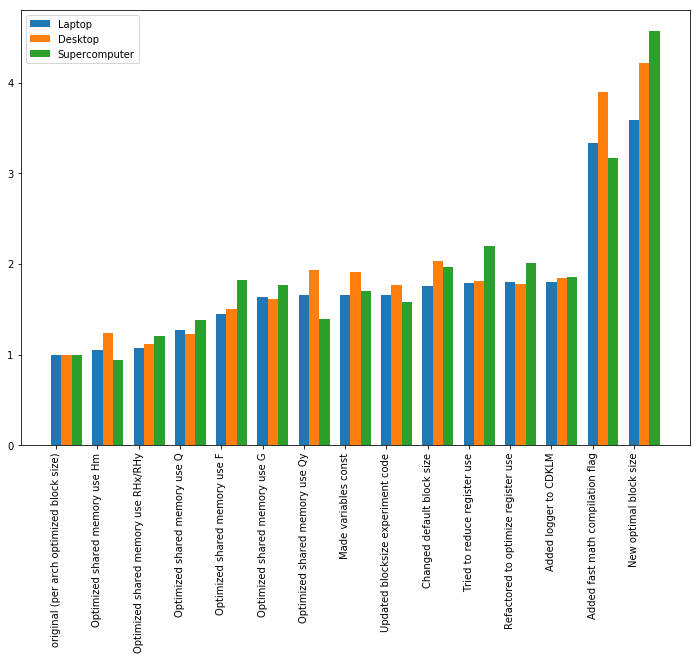

In [26]:
outfile_laptop = outfile
outfile_desktop = outfile
outfile_supercomputer = outfile

with np.load(outfile_laptop) as data:
    versions = data['versions']
    labels = data['labels']
    megacells_laptop = data['megacells']
    normalized_megacells_laptop = megacells_laptop / megacells_laptop[0]
    
with np.load(outfile_desktop) as data:
    assert(np.all(versions == data['versions']))
    megacells_desktop = data['megacells'] * (1.0 + 0.25*np.random.random((len(versions))))
    normalized_megacells_desktop = megacells_desktop / megacells_desktop[0]
    
with np.load(outfile_supercomputer) as data:
    assert(np.all(versions == data['versions']))
    megacells_supercomputer = data['megacells'] * (1.0 + 0.7*np.random.random((len(versions))))
    normalized_megacells_supercomputer = megacells_supercomputer / megacells_supercomputer[0]
    
fig = plt.figure()

fig, ax = plt.subplots(figsize=(12,8))

index = np.arange(len(versions))
bar_width = 0.25

ax.bar(index, normalized_megacells_laptop, bar_width, label='Laptop')
ax.bar(index+bar_width, normalized_megacells_desktop, bar_width, label='Desktop')
ax.bar(index+2*bar_width, normalized_megacells_supercomputer, bar_width, label='Supercomputer')

plt.xticks(index, labels, rotation='vertical')

plt.legend()

In [27]:
shutil.rmtree(tmpdir)
logger.debug("Removed tempdir " + tempdir)

PermissionError: [WinError 5] Ingen tilgang: 'C:\\Users\\anbro\\AppData\\Local\\Temp\\git_tmpxveo_1rg\\git_clone\\.git\\objects\\09\\a2c80b511a302893828319e563736292053917'